In [1]:
import os, glob, re      # File system, path matching, regular expressions
import numpy as np       # Numerical operations
import matplotlib as mpl # Main matplotlib library
import matplotlib.pyplot as plt # Plotting interface
from astropy.io import fits     # FITS file handling
from scipy.optimize import minimize # Optimization functions
from matplotlib.cm import get_cmap # Colormaps
from scipy.signal import find_peaks # Peak finding in signals
from matplotlib.backends.backend_pdf import PdfPages # PDF export for plots
from collections import defaultdict
import cmasher as cmr
from scipy.optimize import curve_fit
from scipy.special import erf
import warnings

plt.rcParams['figure.dpi'] = 400      # Set default DPI for figures
mpl.rcParams['figure.max_open_warning'] = 0 # Suppress warning for too many open figures

In [2]:
# ---------- Globbing Functions ---------- #
# Directory containing DU subfolders (du1, du2, du3, ...)
ROOT_DIR = "/Users/leodrake/Library/CloudStorage/Box-Box/IXPE_rmfs/sim_data_mit" # Adjusted to your path

def list_sim_fits(du_specifier='all', pattern='sim_*_pol_recon*.fits'):
    """
    Return a DU label and sorted FITS paths.

    Parameters
    ----------
    du_specifier : str or list, optional
        If 'all', searches all 'du*' subfolders.
        If a string like 'du1', searches only that subfolder.
        If a list like ['du1', 'du2'], searches those subfolders.
        Defaults to 'all'.
    pattern : str, optional
        The glob pattern for FITS files.

    Returns
    -------
    du_label : str
        A label representing the processed DUs (e.g., 'du1', 'du_all', 'du_du1_du2').
    files : list
        A sorted list of found FITS file paths.
    """
    if not os.path.isdir(ROOT_DIR):
        raise FileNotFoundError(f"ROOT_DIR '{ROOT_DIR}' not found.")

    all_dus = [d for d in os.listdir(ROOT_DIR) if d.lower().startswith('du') and os.path.isdir(os.path.join(ROOT_DIR, d))]

    if isinstance(du_specifier, str) and du_specifier.lower() == 'all':
        subdirs_to_search = all_dus
        du_label = 'du123'
    elif isinstance(du_specifier, str) and du_specifier in all_dus:
        subdirs_to_search = [du_specifier]
        du_label = du_specifier
    elif isinstance(du_specifier, (list, tuple)):
        subdirs_to_search = [d for d in du_specifier if d in all_dus]
        if not subdirs_to_search:
             raise ValueError(f"None of the specified DUs {du_specifier} found in {ROOT_DIR}")
        du_label = f'du-{"-".join(sorted(subdirs_to_search))}'
    else:
        raise ValueError(f"Invalid 'du_specifier': {du_specifier}. Use 'all', a valid DU name, or a list.")

    files = []
    for sd in subdirs_to_search:
        path = os.path.join(ROOT_DIR, sd, pattern)
        files.extend(glob.glob(path))

    if not files:
        print(f"Warning: No FITS files found for '{du_label}' with pattern '{pattern}' in {ROOT_DIR}.")

    return du_label, sorted(files)

def parse_energy(fname):
    """Extract energy in keV from 'sim_01000_...' filename."""
    # Search for energy value (5 digits) in filename
    m = re.search(r'sim_(\d{5})', os.path.basename(fname))
    # Convert matched digits to float in keV, or return NaN if no match
    return int(m.group(1)) / 1000.0 if m else np.nan

In [3]:
# ---------- Helper Functions ---------- #

def bg_flag(alpha, nrg):
    """Determine if events are background based on alpha and energy."""
    # Define parameters for background region boundaries
    a1, a2, nrg0 = 0.35, 0.7, 2.0 # Thresholds and reference energy
    b1 = (1 - a1) / (5.5 - nrg0)   # Slope for first boundary line
    b2 = (0.95 - a2) / (8.0 - nrg0) # Slope for second boundary line
    # Identify events above the defined boundary lines as bad
    bad = (alpha > (a1 + b1 * (nrg - nrg0))) | (alpha > (a2 + b2 * (nrg - nrg0)))
    return ~bad # Return boolean array: True for good events, False for bad

# Extract arrays from simulation FITS (full PI range, no XY cut)
def extract_common_data(d, pi_min, pi_max, bgflag=False):
    """
    Extract pi, nrg_pi, alpha, and phi from simulation FITS using the raw PHA channel.

    Parameters
    ----------
    d : FITS_rec
        The table data for one simulation file.
    pi_min, pi_max : float
        Full-range PI limits in channel units.
    bgflag : bool
        If True, apply the background cut via bg_flag().

    Returns
    -------
    pi, nrg_pi, alpha, phi : tuple of 1D numpy arrays
    """
    # 1) Raw PHA counts (0–32768)
    pha = d['PHA'].astype(float) # Extract PHA (Pulse Height Amplitude) column
    pha2pi = 1.0 / (3000 * 0.04)  # 3000 ADC counts keV^-1, 40eV bins

    # 2) Compute PI channels (0–250) and energy keV (0–10)
    pi_raw  = pha * pha2pi # Convert PHA to PI channels
    nrg_raw = pha / 3000  # 3000 ADC counts keV^-1: https://doi.org/10.1016/j.astropartphys.2021.102628

    # 3) Mask on the full PI range
    ok = (pi_raw > pi_min) & (pi_raw <= pi_max) # Create boolean mask for events within PI range

    # 4) Slice out the selected events
    pi     = pi_raw[ok]       # PI channels for selected events
    nrg_pi = nrg_raw[ok]      # Energy (from PI) for selected events
    tl     = d['TRK_M2L'][ok] # Track length proxy for selected events
    tw     = d['TRK_M2T'][ok] # Track width proxy for selected events
    alpha  = (tl - tw) / (tl + tw) # Calculate alpha parameter (shape parameter)
    phi    = d['DETPHI2'][ok] # Detector phi angle for selected events

    # 5) Optional background filtering
    if bgflag:
        good = bg_flag(alpha, nrg_pi) # Apply background flag
        # Filter data arrays based on good events
        pi, nrg_pi, alpha, phi = (
            pi[good], nrg_pi[good], alpha[good], phi[good]
        )

    return pi, nrg_pi, alpha, phi # Return extracted and filtered arrays

def find_pi_peak_band(pi, bin_width=1, min_prominence=0.1):
    """
    Identify the *highest* peak in the PI histogram via scipy.signal.find_peaks,
    then return its FWHM band.

    Parameters
    ----------
    pi              : 1D array of PI channels
    bin_width       : width of each PI bin
    min_prominence : minimal prominence for find_peaks (fraction of max count)

    Returns
    -------
    pi_min, pi_max : floats
        Lower and upper PI channel bounds of the FWHM around the tallest peak.
    """
    # 1) Histogram the PI data
    pi = np.asarray(pi) # Ensure PI is a numpy array
    lo, hi = int(np.nanmin(pi)), int(np.nanmax(pi)) # Min/max PI values for binning
    bins = np.arange(lo, hi + bin_width, bin_width) # Define histogram bins
    counts, edges = np.histogram(pi, bins=bins)    # Calculate histogram
    centers = (edges[:-1] + edges[1:]) / 2        # Bin centers

    # 2) Find *all* peaks with minimal prominence relative to the max count
    peak_idxs, props = find_peaks(
        counts,
        prominence=min_prominence * counts.max()
    )
    if peak_idxs.size == 0:
        # Fallback: if no peaks found, use the highest single bin
        idx = counts.argmax()
    else:
        # Choose the index of the peak with the largest height among found peaks
        idx = peak_idxs[np.argmax(counts[peak_idxs])]

    # 3) Compute half‐max threshold based on the selected peak's height
    half_max = counts[idx] / 2.0

    # 4) Walk left/right from the peak to find FWHM boundaries
    left = idx # Start search for left FWHM boundary from peak index
    while left > 0 and counts[left] > half_max:
        left -= 1
    right = idx # Start search for right FWHM boundary from peak index
    while right < len(counts)-1 and counts[right] > half_max:
        right += 1

    # 5) Convert FWHM bin indices to PI channel boundaries
    pi_min = centers[left] - bin_width/2
    pi_max = centers[right] + bin_width/2
    return pi_min, pi_max


def get_combined_data(file_list):
    """Reads FITS data from multiple files and concatenates them."""
    all_data = []
    print(f"    Combining data from {len(file_list)} file(s)...")
    for fname in file_list:
        try:
            all_data.append(fits.getdata(fname, 1))
        except Exception as e:
            print(f"    Warning: Could not read {os.path.basename(fname)}: {e}")
    if not all_data:
        return None
    # Ensure all data tables have the same columns before concatenating
    if len(all_data) > 1:
        first_dtype = all_data[0].dtype
        if not all(d.dtype == first_dtype for d in all_data[1:]):
            print("    Warning: FITS files have different structures. Cannot combine.")
            # Optionally, try to combine common columns or just return the first.
            # For now, we'll return None to indicate failure.
            return None
    return np.concatenate(all_data)

# Build step-plot X,Y coordinates for histograms
def step_plot(x, y, binwidth):
    """Create x, y coordinates for a step plot from histogram data."""
    xsteps, ysteps = [], [] # Initialize lists for step plot coordinates
    # For each bin, create two x (left/right edge) and two y (height) points
    for xi, yi in zip(x, y):
        xsteps += [xi - binwidth/2, xi + binwidth/2]
        ysteps += [yi, yi]
    return xsteps, ysteps

# Plot XY vs Time and φ vs α (Unchanged, but not explicitly used by generate_summary_plots)
def plot_xy_vs_t(d, pi_min, pi_max, alpha_min, title):
    """Generates plots for XY vs Time and phi vs alpha."""
    # Extract data; bgflag is False by default here
    pi, nrg_pi, alpha, phi = extract_common_data(d, pi_min, pi_max, bgflag=False)
    time0 = d['TIME'] - np.min(d['TIME']) # Normalize time to start from 0
    X, Y = d['ABSX'], d['ABSY'] # Absolute X and Y coordinates
    figs = [] # List to store generated figures

    # φ histogram
    dphi = 0.001 * np.pi # Bin width for phi histogram
    phist, edges = np.histogram(phi, bins=np.arange(-np.pi, np.pi + dphi, dphi)) # Compute phi histogram
    pval = (edges[:-1] + edges[1:]) / 2 # Phi bin centers
    xs, ys = step_plot(pval, phist, dphi) # Get step plot coordinates
    fig, ax = plt.subplots(); ax.plot(xs, ys); ax.set(title=f'{title} – φ dist', xlabel='φ'); figs.append(fig)

    # φ vs α scatter plot
    fig, ax = plt.subplots(); ax.scatter(phi, alpha, s=1) # s=1 for small marker size
    ax.set(title=f'{title} – φ vs α', xlabel='φ', ylabel='α'); figs.append(fig)
    return figs

# Plot PI & α distributions (Unchanged)
def plot_pi_alpha(d, pi_min, pi_max, title, dist_component='Full', a_color='blueviolet'):
    """Generates plots for PI and alpha distributions."""
    # Extract data; bgflag is False by default here
    pi, _, alpha, _ = extract_common_data(d, pi_min, pi_max, bgflag=False)
    figs = [] # List to store generated figures

    # PI distribution plot
    phist, edges = np.histogram(pi, bins=np.arange(pi_min, pi_max+1, 1)) # PI histogram (bin width 1)
    pval = (edges[:-1] + edges[1:]) / 2 # PI bin centers
    xs, ys = step_plot(pval, phist, 1) # Get step plot coordinates
    fig, ax = plt.subplots(); ax.plot(xs, ys, 'k', label=f'{dist_component} distribution')
    ax.set(title=f'{title} – PI dist', xlabel='PI'); figs.append(fig)
    ax.legend()

    # α distribution plot
    ahist, edges = np.histogram(alpha, bins=np.arange(0, 1.0, 0.01)) # Alpha histogram (bin width 0.01)
    aval = (edges[:-1] + edges[1:]) / 2 # Alpha bin centers
    xs, ys = step_plot(aval, ahist, 0.01) # Get step plot coordinates
    fig, ax = plt.subplots(); ax.plot(xs, ys, a_color, label=f'{dist_component} distribution')
    ax.set(title=f'{title} – α dist', xlabel='α'); figs.append(fig)
    ax.legend()
    return figs

In [4]:
# ---------- Fitting Functions ---------- #

def minimizer(func, p0, args=(), tol=1e-6):
    """Wrapper for scipy.optimize.minimize using Nelder-Mead method."""
    # Perform minimization
    res = minimize(func, p0, args=args, method='Nelder-Mead', tol=tol)
    return res.x # Return the optimal parameters

def safe_polar_likelihood_1d(param, ci):
    """Calculates -2*log-likelihood for 1D polarization, with penalty for invalid parameters."""
    # param is modulation factor mu, ci is cos(2*phase_i)
    val = 1 + param * ci # Argument of the logarithm in likelihood function
    # If any argument is non-positive, return a large penalty value (high cost)
    if np.any(val <= 0):
        return 1e6 + 1e3 * abs(param)
    return -2 * np.sum(np.log(val)) # Standard -2*log-likelihood

def invert_matrix(matrix):
    """Safely inverts a matrix, handling potential LinAlgError."""
    try:
        return 0, np.linalg.inv(matrix) # Return 0 (success) and inverted matrix
    except np.linalg.LinAlgError:
        return 1, None # Return 1 (error) and None

def polar_likelihood(param, evtq, evtu):
    """Calculates -2*log-likelihood for Stokes Q, U parameters."""
    q, u = param # Unpack Stokes Q and U from parameters
    arg = 1 + q*evtq + u*evtu # Argument of log: 1 + Q*cos(2*phi) + U*sin(2*phi)
    # Raise error if any argument is non-positive (log undefined)
    if np.any(arg <= 0):
        raise ValueError("Non-positive argument encountered in log")
    return -2 * np.sum(np.log(arg)) # Sum of -2*log values for all events

def polar_evpa_likelihood(param, evtq, evtu):
    """Calculates -2*log-likelihood for polarization degree (P) and angle (EVPA)."""
    dtor = np.pi/180.0 # Degrees to radians conversion factor
    # Convert P, EVPA to Q, U
    q = param[0]*np.cos(2*param[1]*dtor) # param[0] is P, param[1] is EVPA
    u = param[0]*np.sin(2*param[1]*dtor)
    arg = 1 + q*evtq + u*evtu # Argument of log
    # Raise error if any argument is non-positive
    if np.any(arg <= 0):
        raise ValueError("Non-positive argument encountered in log")
    return -2 * np.sum(np.log(arg)) # Sum of -2*log values

def pderiv(func, x, i, dx):
    """Computes partial derivative of func w.r.t. x[i] using central difference."""
    x0, x1 = x.copy(), x.copy() # Create copies of parameter vector
    x0[i] -= 0.5*dx # Perturb parameter x[i] backward
    x1[i] += 0.5*dx # Perturb parameter x[i] forward
    return (func(x1) - func(x0)) / dx # Central difference formula

def pderiv2(func, x, dx):
    """Computes the Hessian matrix (matrix of second partial derivatives) of func."""
    n = len(x) # Number of parameters
    H = np.zeros((n,n)) # Initialize Hessian matrix
    # Iterate over upper triangle of the Hessian
    for i in range(n):
        for j in range(i, n):
            x0, x1 = x.copy(), x.copy()
            # Perturb x[i] to compute derivative w.r.t x[j]
            x0[i] -= 0.5*dx[i]; x1[i] += 0.5*dx[i]
            # Compute partial derivative of (d func / d x[j]) at x0 and x1
            pd0 = pderiv(func, x0, j, dx[j])
            pd1 = pderiv(func, x1, j, dx[j])
            # Second derivative (d^2 func / dx[i]dx[j])
            H[i,j] = (pd1 - pd0)/dx[i]
    # Symmetrize the Hessian (H[j,i] = H[i,j])
    return H + H.T - np.diag(np.diagonal(H))

def likelihood(evtq, evtu):
    """Estimates Stokes Q, U, polarization degree, EVPA, and errors."""
    # evtq = cos(2*phi_i), evtu = sin(2*phi_i) for each event i
    sumq2 = np.sum(evtq**2) # Sum of cos^2(2*phi_i)
    sumu2 = np.sum(evtu**2) # Sum of sin^2(2*phi_i)

    # Simple (approximate) initial estimates for Q, U errors
    qu_err_init = np.array([1/np.sqrt(sumq2) if sumq2>0 else np.nan,
                            1/np.sqrt(sumu2) if sumu2>0 else np.nan])
    # Simple initial estimates for Q, U values
    qu0 = np.array([np.sum(evtq)*(qu_err_init[0]**2) if sumq2>0 else 0.0,
                    np.sum(evtu)*(qu_err_init[1]**2) if sumu2>0 else 0.0])

    # Fit Q,U using Nelder-Mead minimization of polar_likelihood
    initial_like_val = 0 # Initialize
    try:
        initial_like_val = polar_likelihood(qu0, evtq, evtu) # Calculate initial likelihood
        # Set tolerance for minimizer based on initial likelihood value
        tol = abs(0.01 / initial_like_val) if initial_like_val != 0 and (sumq2 + sumu2 > 0) else 1e-6
    except ValueError: # Catch potential log error if qu0 is problematic
        tol = 1e-6

    try:
        # Perform minimization to find best-fit Q, U
        qu = minimizer(polar_likelihood, qu0, args=(evtq, evtu), tol=tol)
    except ValueError: # If minimizer fails due to initial values
        qu = qu0.copy() # Use initial estimates
    except Exception: # Catch other minimization errors
        qu = qu0.copy() # Use initial estimates

    # Error estimation from Hessian matrix of the likelihood function
    qu_err_fit = qu_err_init.copy() # Default to initial error estimates
    try:
        # Step sizes for numerical differentiation, use initial errors or small default
        hess_dx = qu_err_init if np.all(np.isfinite(qu_err_init)) and np.all(qu_err_init > 0) else np.ones_like(qu_err_init)*1e-3
        # Compute Hessian (0.5 factor for -2logL)
        H = 0.5 * pderiv2(lambda x: polar_likelihood(x, evtq, evtu), qu, hess_dx)
        err_code, M = invert_matrix(H) # Invert Hessian to get covariance matrix
        if M is not None: # If inversion successful
            qu_err_fit = np.sqrt(np.abs(np.diag(M))) # Errors are sqrt of diagonal elements
        else: # If inversion failed
            qu_err_fit = np.array([np.nan, np.nan])
    except: # Catch any other errors during Hessian calculation/inversion
        qu_err_fit = np.array([np.nan, np.nan])

    # Calculate polarization degree (poln) and electric vector position angle (evpa)
    poln = np.linalg.norm(qu) # Polarization degree: sqrt(Q^2 + U^2)
    evpa = 0.5 * np.arctan2(qu[1], qu[0]) * (180.0/np.pi) # EVPA in degrees

    # Minimum Detectable Polarization (MDP) estimate
    mdp = 4.29/np.sqrt(sumq2+sumu2) if sumq2+sumu2>0 else np.nan
    # Return initial Q,U (qu0), their errors (qe0=qu_err_init),
    # fitted Q,U (qu), their errors (qe=qu_err_fit),
    # polarization degree (poln), its error (nan), EVPA, its error (nan),
    # change in likelihood (nan), and MDP.
    # Note: Errors for poln and evpa are not calculated here via propagation from Q,U errors.
    return qu0, qu_err_init, qu, qu_err_fit, poln, np.nan, evpa, np.nan, np.nan, mdp

def fit_mu_alpha(d, pi_min, pi_max, nalpha, title, bgflag=False):
    """
    IDL-style fit_mu_alpha for SIM data, full-PI.
    Fits modulation factor mu in bins of alpha.

    Returns: (outputs_dict, list_of_figures)
    """
    # 1) Extract common data arrays (pi, energy, alpha, phi)
    pi, nrg_pi, alpha, phi = extract_common_data(d, pi_min, pi_max, bgflag)
    figs = [] # Initialize list to store figures

    # 3) Phi distribution + model (Step 2 from IDL might be implicit or handled elsewhere)
    dphi = 0.001 * np.pi # Bin width for phi histogram
    phist, edges = np.histogram(phi, bins=np.arange(-np.pi, np.pi + dphi, dphi)) # Compute phi histogram
    phival = (edges[:-1] + edges[1:]) / 2 # Phi bin centers
    evtq = np.cos(2*phi); evtu = np.sin(2*phi) # Per-event Q and U proxies

    # Handle cases with no events in the selected PI band
    if len(evtq) == 0 or len(evtu) == 0:
        # Prepare an empty output structure
        outputs = {
            "mu_noweight": np.nan, "mu_noweight_err": np.nan,
            "alpha_bins": (np.arange(nalpha)+0.5)*(1.0/float(nalpha)),
            "mu_bins": np.full(nalpha, np.nan), "mu_bins_err": np.full(nalpha, np.nan),
            "nevt_bins": np.zeros(nalpha, int)
        }
        # Create an empty placeholder plot for phi distribution
        phi_fig, phi_ax = plt.subplots()
        phi_ax.set(title=rf"{title} – $\phi$ Dist. (No Data)", xlabel=r"$\phi$")
        figs.append(phi_fig)
        return outputs, figs

    # Calculate overall Q, U, polarization, etc. using the likelihood function
    qu0, qe0, qu, qe, mu_nw, mu_nw_err, evpa, evpa_err, dlike, mdp = likelihood(evtq, evtu)

    # Model for the phi distribution plot
    # Correct normalization: number of φ-bins = len(phist)
    nbin_phi_hist = len(phist) # Number of bins in the phi histogram
    model = np.zeros_like(phival) # Initialize model array
    # Calculate model if there are events and histogram bins
    if nbin_phi_hist > 0 and len(phi) > 0:
        # Model: N_total * (1 + Q*cos(2*phi_val) + U*sin(2*phi_val)) / N_bins
        model = len(phi) * (1 + qu[0]*np.cos(2*phival) + qu[1]*np.sin(2*phival)) / nbin_phi_hist
    else: # If no phi values, fill model with NaNs
        model.fill(np.nan)

    # Plot phi distribution with the fitted model
    xs2, ys2 = step_plot(phival, phist, dphi) # Coordinates for step plot of histogram
    phi_fig, phi_ax = plt.subplots()
    phi_ax.plot(xs2, ys2, 'darkseagreen', alpha=0.75, label="Data") # Plot histogram
    phi_ax.plot(phival, model, 'k', label="Model") # Plot model
    phi_ax.set(title=rf"{title} – $\phi$ Dist.", xlabel=r"$\phi$")
    # phi_ax.legend() # Optional: add legend if desired
    figs.append(phi_fig)

    # 4) Modulation μ in α-bins via phase histograms
    # Calculate phase relative to the fitted EVPA
    # Handle qu being all NaNs (e.g., if likelihood fit failed or no data)
    phase = (phi - 0.5*np.arctan2(qu[1], qu[0])) % np.pi if not np.all(np.isnan(qu)) else np.full_like(phi, np.nan)
    dalpha = 1.0/float(nalpha) # Width of each alpha bin
    alpha_centers = (np.arange(nalpha)+0.5)*dalpha # Center of each alpha bin

    mu_bins = np.zeros(nalpha)      # Initialize array for mu values in alpha bins
    mu_err  = np.full(nalpha, np.nan) # Initialize array for mu errors (with NaNs)
    nevt    = np.zeros(nalpha, int) # Initialize array for number of events in alpha bins

    MIN_EVENTS = 100 # Minimum number of events required in an alpha bin to perform fit

    # Iterate over alpha bins to fit mu
    for i, ac in enumerate(alpha_centers):
        # Select events within the current alpha bin
        sel = np.where((alpha >= ac - dalpha/2) & (alpha < ac + dalpha/2))[0]
        nevt[i] = sel.size # Number of events in this bin

        # Only fit this bin if enough events and phase is valid
        if nevt[i] < MIN_EVENTS or np.all(np.isnan(phase)):
            mu_bins[i] = np.nan # Not enough events or invalid phase, set mu to NaN
            continue # Skip to next alpha bin

        ci = np.cos(2*phase[sel]) # cos(2*aligned_phase) for selected events
        # Initial guess for mu parameter for 1D likelihood fit
        p0 = np.array([np.sum(ci)/np.sum(ci*ci)]) if np.sum(ci*ci)>0 else np.array([0.0])
        # Fit mu using safe_polar_likelihood_1d minimizer
        mu_bins[i] = minimizer(safe_polar_likelihood_1d, p0, args=(ci,), tol=1e-6)[0]
        # Calculate error for mu_bins[i] from the likelihood curvature (1/sqrt(Fisher_information))
        denom = np.sum(ci*ci/((1+mu_bins[i]*ci)**2)) # Denominator for error calculation
        mu_err[i] = np.sqrt(1/denom) if denom>0 else np.nan

        # Optional: Generate phase-plot for this alpha bin if needed for diagnostics
        # (Currently, this plot is generated for every valid bin)
        pbin = 0.01*np.pi # Bin width for phase histogram in this alpha bin
        ph2, ed2 = np.histogram(phase[sel], bins=np.arange(0,np.pi+pbin,pbin)) # Histogram of aligned phases
        pv2 = (ed2[:-1]+ed2[1:])/2 # Phase bin centers
        norm = ph2/ph2.sum() if ph2.sum() > 0 else ph2 # Normalized counts (density)
        model_ph = 0.01*(1+mu_bins[i]*np.cos(2*pv2)) # Model for phase distribution: (1 + mu*cos(2*phase_val)) * dPhase

        fig, ax = plt.subplots()
        xs3, ys3 = step_plot(pv2, norm, pbin) # Coordinates for step plot
        ax.plot(xs3, ys3, 'darkseagreen', label="Data")
        ax.plot(pv2, model_ph, 'k--', label=rf"$\mu={mu_bins[i]:.2f}$") # Plot model with fitted mu
        ax.set(title=f"{title} – {ac-dalpha/2:.1f}<α<{ac+dalpha/2:.1f}",
               xlabel="Phase (rel. to EVPA)", ylabel="Normalized Counts")
        ax.legend()
        figs.append(fig)

    # Store results in a dictionary
    outputs = {
        "mu_noweight": mu_nw,           # Overall modulation factor (no alpha weighting)
        "mu_noweight_err": mu_nw_err,   # Error for mu_noweight
        "alpha_bins": alpha_centers,    # Centers of alpha bins
        "mu_bins": mu_bins,             # Fitted mu in each alpha bin
        "mu_bins_err": mu_err,          # Error of mu in each alpha bin
        "nevt_bins": nevt               # Number of events in each alpha bin
    }
    return outputs, figs # Return results dictionary and list of figures

In [5]:
# ---------- Summary Figures ---------- #
def peak_with_erf_tail(E, A_peak, E_break, alpha1, alpha2, C_tail, E_trans, W_trans):
    """
    A broken power-law peak that smoothly transitions to a flat, constant tail.
    C_tail: The constant height of the flat tail.
    E_trans: The energy where the transition to the tail occurs.
    W_trans: The width (speed) of the erf transition.
    """
    # Create the broken power-law core shape
    if E_break <= 0:
        return np.full_like(E, np.inf)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        term1 = (E / E_break)**(-alpha1)
        term2 = (E / E_break)**(-alpha2)
        peak = A_peak * (term1 + term2)**(-1)
    
    # Create the erf-based switch (goes smoothly from 0 to 1)
    switch = (1 + erf((E - E_trans) / W_trans)) / 2.0
    
    # Combine the two parts
    return peak * (1 - switch) + C_tail * switch

def compute_model(eplot, aa=-0.28, bb=0.2, cc=0.21, dd=1./24.):
    """
    Compute the IDL-like empirical model for modulation factor mu vs. energy.
    Model: mu = (1 / [(-aa - bb*E)^-4 + (-cc - dd*E)^-4])^0.25,
    handling non-finite values.
    """
    # Calculate the two terms in the denominator
    term1 = (-aa - bb * eplot)**(-4)
    term2 = (-cc - dd * eplot)**(-4)
    # Compute model, suppressing errors for invalid operations (e.g., division by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        model = (1.0 / (term1 + term2))**0.25
        model[~np.isfinite(model)] = np.nan # Set non-finite results (e.g. from negative bases) to NaN
    return model

def generate_summary_sim_plots(energies_list, peak_results_list, low_results_list, du_label, filename="summary_plots_sim.pdf"):
    """
    Create a multipage PDF of summary plots for simulation data using only the Erf Tail model.
    """
    # --- Preliminary Filtering of Input Data ---
    def result_is_valid(res):
        """Helper function to check if a result dictionary is valid (contains finite mu_noweight)."""
        return (
            res is not None and
            ("mu_noweight" in res) and
            np.isfinite(res["mu_noweight"])
        )

    valid_indices = [
        i for i, (p, l, e) in enumerate(zip(peak_results_list, low_results_list, energies_list))
        if result_is_valid(p) and result_is_valid(l) and np.isfinite(e)
    ]

    if not valid_indices:
        print(f"Error: No valid results found for DU {du_label}. Cannot generate summary plots.")
        return

    energies = np.array([energies_list[i] for i in valid_indices])
    peak_results = [peak_results_list[i] for i in valid_indices]
    low_results  = [low_results_list[i] for i in valid_indices]

    if len(energies) == 0:
        print(f"Error: No valid data remain after filtering for DU {du_label}. Cannot generate summary plots.")
        return

    print(f"\nGenerating summary plots for {len(energies)} valid simulations ({du_label}) in '{filename}'...")

    # --- Precompute Event Counts and Weighted mu ---
    tot_hi = np.array([np.sum(res["nevt_bins"]) if "nevt_bins" in res and res["nevt_bins"] is not None else 0 for res in peak_results])
    tot_lo = np.array([np.sum(res["nevt_bins"]) if "nevt_bins" in res and res["nevt_bins"] is not None else 0 for res in low_results])
    valid_evt_mask = ((tot_hi + tot_lo) > 0)
    mu_noweight_hi = np.array([res["mu_noweight"] for res in peak_results])
    mu_noweight_hi_err = np.array([res["mu_noweight_err"] for res in peak_results])
    mu_noweight_lo = np.array([res["mu_noweight"] for res in low_results])
    mu_noweight_lo_err = np.array([res["mu_noweight_err"] for res in low_results])
    mu_noweight_combined = np.full_like(mu_noweight_hi, np.nan)
    numerator_combined = np.nan_to_num(tot_hi * mu_noweight_hi) + np.nan_to_num(tot_lo * mu_noweight_lo)
    denominator_combined = tot_hi + tot_lo
    mu_noweight_combined[valid_evt_mask] = numerator_combined[valid_evt_mask] / denominator_combined[valid_evt_mask]

    # --- Model Curves ---
    eplot = np.linspace(min(energies), max(energies), 500)
    mu_model_orig   = compute_model(eplot, aa=-0.28, bb=0.2, cc=0.21, dd=1./24.)
    mu_model_better = compute_model(eplot, aa=-0.28, bb=0.2, cc=0.21, dd=1./18.5)

    with PdfPages(filename) as pdf:
        # --- Pages 1-4: Standard Summary Plots ---
        fig1, ax1 = plt.subplots();
        ax1.errorbar(energies, mu_noweight_hi, yerr=mu_noweight_hi_err, c='deeppink', fmt='.', capsize=3, label="Peak PI")
        ax1.errorbar(energies, mu_noweight_lo, yerr=mu_noweight_lo_err, c='cornflowerblue', fmt='s', markersize=3, capsize=3, label="Low PI")
        ax1.plot(energies, mu_noweight_combined, 'd', markersize=3, c='blueviolet', label="All PI")
        ax1.plot(eplot, mu_model_better, 'k', label="Peak Only Model", zorder=10)
        ax1.plot(eplot, mu_model_orig, 'k--', label="All PI Model (Di Marco+)", zorder=9)
        ax1.set(xlabel="Energy (keV)", ylabel=r"$\mu$", title=f"IXPE Simulations {du_label}"); ax1.legend()
        pdf.savefig(fig1); plt.close(fig1)

        a_ref, b_ref = 0.05, 0.8; a_line_ref = np.linspace(0,1,200); mu_line_ref = a_ref + b_ref*a_line_ref
        norm = plt.Normalize(vmin=np.min(energies), vmax=np.max(energies))
        fig2, ax2 = plt.subplots();
        for E_val, res_dict in zip(energies, peak_results):
            mask = res_dict["nevt_bins"] > 100
            ax2.plot(res_dict["alpha_bins"][mask], res_dict["mu_bins"][mask], color=plt.cm.rainbow_r(norm(E_val)), lw=1)
        ax2.plot(a_line_ref, mu_line_ref, 'k--', linewidth=3, label="Di Marco et al.")
        ax2.set(title="Peak PI: μ vs α", xlabel="α", ylabel="μ"); ax2.legend()
        fig2.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="rainbow_r"), ax=ax2, label="Energy (keV)")
        plt.tight_layout(); pdf.savefig(fig2); plt.close(fig2)

        fig3, ax3 = plt.subplots()
        for E_val, res_dict in zip(energies, low_results):
            mask = res_dict["nevt_bins"] > 100
            ax3.plot(res_dict["alpha_bins"][mask], res_dict["mu_bins"][mask], color=plt.cm.rainbow_r(norm(E_val)), lw=1)
        ax3.plot(a_line_ref, mu_line_ref, 'k--', linewidth=3, label="Di Marco et al.")
        ax3.set(title="Low PI: μ vs α", xlabel="α", ylabel="μ"); ax3.legend()
        fig3.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="rainbow_r"), ax=ax3, label="Energy (keV)")
        plt.tight_layout(); pdf.savefig(fig3); plt.close(fig3)
        
        fig4, ax4 = plt.subplots()
        a_model_linear, b_model_linear = 0.05, 0.8
        for E_val, res_dict in zip(energies, peak_results):
            mask = res_dict["nevt_bins"] > 100
            mu_improvement = res_dict["mu_bins"] - (a_model_linear + b_model_linear * res_dict["alpha_bins"])
            ax4.plot(res_dict["alpha_bins"][mask], mu_improvement[mask], color=plt.cm.rainbow_r(norm(E_val)), linewidth=1)
        ax4.axhline(0, color='k', linestyle='--', linewidth=3)
        ax4.set(title="Peak PI: Model Improvement", xlabel="α", ylabel="μ − model (linear)")
        fig4.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="rainbow_r"), ax=ax4, label="Energy (keV)")
        plt.tight_layout(); pdf.savefig(fig4); plt.close(fig4)

        # --- Page 5+: mu vs. Energy for each alpha bin ---
        print("   -> Generating μ vs. Energy plots for each alpha bin...")
        n_alpha_bins = len(peak_results[0]["alpha_bins"])
        alpha_bin_centers = peak_results[0]["alpha_bins"]
        d_alpha = 1.0 / n_alpha_bins
        erf_tail_params_log = []
        erf_tail_params_log_low = []
        
        last_successful_ebreak_peak = None
        last_successful_ebreak_low = None
        
        for i in range(n_alpha_bins):
            alpha_low, alpha_high = alpha_bin_centers[i] - d_alpha/2.0, alpha_bin_centers[i] + d_alpha/2.0
            mu_peak_slice = np.array([res['mu_bins'][i] for res in peak_results])
            mu_err_peak_slice = np.array([res['mu_bins_err'][i] for res in peak_results])
            mu_low_slice = np.array([res['mu_bins'][i] for res in low_results])
            mu_err_low_slice = np.array([res['mu_bins_err'][i] for res in low_results])

            fig5, ax5 = plt.subplots()
            ax5.errorbar(energies, mu_peak_slice, yerr=mu_err_peak_slice, c='deeppink', fmt='.', capsize=3, label="Peak PI")
            ax5.errorbar(energies, mu_low_slice, yerr=mu_err_low_slice, c='cornflowerblue', fmt='s', markersize=3, capsize=3, label="Low PI")
            
            e_fit_plot = np.linspace(energies.min(), energies.max(), 200)
            erf_tail_params_this_bin = [np.nan] * 7
            erf_tail_params_this_bin_low = [np.nan] * 7

            # Fit Peak PI data
            mask_peak = np.isfinite(mu_peak_slice) & (mu_err_peak_slice > 0)
            if np.sum(mask_peak) > 6:
                x_peak, y_peak, yerr_peak = energies[mask_peak], mu_peak_slice[mask_peak], mu_err_peak_slice[mask_peak]
                try:
                    p0_erf = [2 * alpha_high, 2, 6, -2.0, 0.1, 6.0, 2.0]
                    
                    lower_bounds = [2 * alpha_high - 0.001, 1.5, 5, -np.inf, 0, 4, 0.1]
                    upper_bounds = [2 * alpha_high + 0.001, 6, np.inf, 0, 1, 12, 10]
                    
                    if last_successful_ebreak_peak is not None:
                        lower_bounds[1] = last_successful_ebreak_peak
                        p0_erf[1] = last_successful_ebreak_peak # --- MODIFIED: Update initial guess ---
                    
                    bounds_erf = (lower_bounds, upper_bounds)
                    popt_erf, _ = curve_fit(peak_with_erf_tail, x_peak, y_peak, p0=p0_erf, sigma=yerr_peak, maxfev=10000, bounds=bounds_erf)
                    
                    ax5.plot(e_fit_plot, peak_with_erf_tail(e_fit_plot, *popt_erf), color='k', ls='-', lw=2, label='Erf Tail (Peak PI)')
                    erf_tail_params_this_bin = popt_erf
                    last_successful_ebreak_peak = popt_erf[1] 
                except (RuntimeError, ValueError):
                    pass
            
            erf_tail_params_log.append(erf_tail_params_this_bin)

            # Fit Low PI data
            mask_low = np.isfinite(mu_low_slice) & (mu_err_low_slice > 0)
            if np.sum(mask_low) > 4:
                x_low, y_low, yerr_low = energies[mask_low], mu_low_slice[mask_low], mu_err_low_slice[mask_low]
                try:
                    p0_erf_low = [1, 3, 2.0, -2.0, 0.1, 6.0, 0.5]

                    lower_bounds_low = [0, 2, 0, -np.inf, 0, 4, 0.1]
                    upper_bounds_low = [2, 6, np.inf, 0, np.inf, 12, 1]
                    
                    if last_successful_ebreak_low is not None:
                        lower_bounds_low[1] = last_successful_ebreak_low
                        p0_erf_low[1] = last_successful_ebreak_low # --- MODIFIED: Update initial guess ---
                    
                    bounds_erf_low = (lower_bounds_low, upper_bounds_low)
                    popt_erf_low, _ = curve_fit(peak_with_erf_tail, x_low, y_low, p0=p0_erf_low, sigma=yerr_low, maxfev=10000, bounds=bounds_erf_low)
                    
                    ax5.plot(e_fit_plot, peak_with_erf_tail(e_fit_plot, *popt_erf_low), color='k', ls='--', lw=1.5, label='Erf Tail (Low PI)')
                    erf_tail_params_this_bin_low = popt_erf_low
                    last_successful_ebreak_low = popt_erf_low[1]
                except (RuntimeError, ValueError):
                    pass
            
            erf_tail_params_log_low.append(erf_tail_params_this_bin_low)

            ax5.set(xlabel="Energy (keV)", ylabel=r"$\mu$", title=fr"Modulation vs. Energy for ${alpha_low:.2f} \leq \alpha < {alpha_high:.2f}$")
            ax5.legend(); ax5.grid(True, linestyle='--', alpha=0.6); ax5.set_ylim(-0.15, 1.05)
            pdf.savefig(fig5); plt.close(fig5)

        # --- Final Parameter Summary Plots ---
        print("   -> Generating parameter vs. alpha plots...")
        erf_param_names = ['Peak Amp (A_peak)', 'Break Energy (E_break)', 'Rise Index (α1)', 'Fall Index (α2)', 'Tail Height (C_tail)', 'Transition Energy (E_trans)', 'Transition Width (W_trans)']
        
        # Plot for Peak PI parameters
        erf_params = np.array(erf_tail_params_log)
        fig_erf, axes_erf = plt.subplots(4, 2, figsize=(12, 16), constrained_layout=True)
        fig_erf.suptitle('Peak + Erf Tail Fit Parameters vs. α (Peak PI)', fontsize=16)
        if len(erf_param_names) % 2 != 0: axes_erf.flat[-1].set_visible(False)
        for idx, ax in enumerate(axes_erf.flat):
            if idx < len(erf_param_names):
                ax.plot(alpha_bin_centers, erf_params[:, idx], 'o-', color='deeppink')
                ax.set(title=erf_param_names[idx], xlabel='α bin center', ylabel='Parameter Value'); ax.grid(True, ls=':')
        pdf.savefig(fig_erf); plt.close(fig_erf)

        # --- NEW: Plot for Low PI parameters ---
        erf_params_low = np.array(erf_tail_params_log_low)
        fig_erf_low, axes_erf_low = plt.subplots(4, 2, figsize=(12, 16), constrained_layout=True)
        fig_erf_low.suptitle('Peak + Erf Tail Fit Parameters vs. α (Low PI)', fontsize=16)
        if len(erf_param_names) % 2 != 0: axes_erf_low.flat[-1].set_visible(False)
        for idx, ax in enumerate(axes_erf_low.flat):
            if idx < len(erf_param_names):
                ax.plot(alpha_bin_centers, erf_params_low[:, idx], 'o-', color='cornflowerblue')
                ax.set(title=erf_param_names[idx], xlabel='α bin center', ylabel='Parameter Value'); ax.grid(True, ls=':')
        pdf.savefig(fig_erf_low); plt.close(fig_erf_low)

    print(f"Summary plots saved to '{filename}'.")

In [6]:
# 1. DEFINE YOUR DATASETS
#    Maps a short label to the actual subdirectory name.
DATASET_CONFIG = {
    "original": "sim_data_mit",
    "scrambled_80": "scrambled_sim_data_80percent",
    "scrambled_50": "scrambled_sim_data_50percent"
}
BASE_PATH = "/Users/leodrake/Library/CloudStorage/Box-Box/IXPE_rmfs"


# 2. CHOOSE WHICH DATASET TO PROCESS FOR THIS RUN
#    <<<<< CHANGE THIS VALUE to "original", "scrambled_80", etc. >>>>>
CURRENT_DATASET_KEY = "original"


# 3. DERIVE PATHS AND LABELS (This part is automatic)
try:
    INPUT_SUBDIR = DATASET_CONFIG[CURRENT_DATASET_KEY]
    ROOT_DIR = os.path.join(BASE_PATH, INPUT_SUBDIR)
    
    # Create a filename suffix ONLY if the dataset is not the original one
    if CURRENT_DATASET_KEY == 'original':
        output_suffix = ''  # The suffix is empty for the original dataset
    else:
        output_suffix = f'-{CURRENT_DATASET_KEY}' # For all others, it's '-key'

    print(f" Processing dataset: '{CURRENT_DATASET_KEY}'")
    print(f"   - Input Directory (ROOT_DIR): '{ROOT_DIR}'")
    print(f"   - Output filename suffix: '{output_suffix}'")
except KeyError:
    raise KeyError(f"Dataset key '{CURRENT_DATASET_KEY}' not found in DATASET_CONFIG. Available keys: {list(DATASET_CONFIG.keys())}")


# 4. OTHER SETTINGS
du_specifier = 'all'
force_recompute = False
generate_individual_plots = True

# ===================================================================
# --- END OF CONFIGURATION ---
# ===================================================================

 Processing dataset: 'original'
   - Input Directory (ROOT_DIR): '/Users/leodrake/Library/CloudStorage/Box-Box/IXPE_rmfs/sim_data_mit'
   - Output filename suffix: ''


In [7]:
# Ensure the root directory for FITS files exists
if not os.path.isdir(ROOT_DIR):
    print(f"Error: ROOT_DIR '{ROOT_DIR}' not found. Please check the path.")
else:
    print(f"--- Processing {du_specifier} ---")
    if force_recompute:
        print("--- Caching is OFF (force_recompute = True) ---")

    # Set the current working directory (adjust if this path is specific to your setup)
    try:
        os.chdir('/Users/leodrake/Documents/MIT/IXPE') # adjust if needed
        print(f"Working directory set to: {os.getcwd()}")
    except FileNotFoundError:
        print(f"Warning: Could not change directory to '/Users/leodrake/Documents/MIT/IXPE'. Using current: {os.getcwd()}")


    # Get list of FITS files and the DU label
    du_label, fits_files = list_sim_fits(du_specifier=du_specifier)

    if not fits_files:
        print(f"No FITS files found for {du_label} in {ROOT_DIR}. Exiting.")
    else:
        # Group files by energy
        files_by_energy = defaultdict(list)
        for fname in fits_files:
            energy = parse_energy(fname)
            if not np.isnan(energy):
                files_by_energy[energy].append(fname)
        
        all_energies_found = sorted(files_by_energy.keys())
        
        #energies_to_process = [e for e in all_energies_found if (e >= 2.0 and e < 9.0)]
        energies_to_process = [e for e in all_energies_found if e <= 8.0]
        #energies_to_process = all_energies_found
        
        print(f"Found {len(fits_files)} files across {len(energies_to_process)} energy points for '{du_label}'.")
        print(f"--> Processing {len(energies_to_process)} energy points with E < 9.0 keV.")

        # Create a directory for caching fit results
        cache_dir = f'NewRMFsADP/fit-cache-{du_label}{output_suffix}'
        os.makedirs(cache_dir, exist_ok=True) # Create if it doesn't exist

        # Lists to store results from all files for this DU, for summary plots
        all_energies_for_du = []
        all_peak_results_for_du = []
        all_low_results_for_du = []

        # Define output PDF filename for individual file plots
        output_pdf_individual = f'process-all-sim-{du_label}{output_suffix}.pdf'
        pdf = None # Initialize pdf object to None
        
        if generate_individual_plots:
            print(f"Individual file plots will be saved to: {os.path.join(os.getcwd(), output_pdf_individual)}")
            pdf = PdfPages(output_pdf_individual) # Open PDF only if needed

        # Loop through each energy point
        for EkeV_current_file in energies_to_process:
            base_name = f"sim-{EkeV_current_file*1000:05.0f}-{du_label}"
            cache_path_peak = os.path.join(cache_dir, f"{base_name}-peak.npz")
            cache_path_low = os.path.join(cache_dir, f"{base_name}-low.npz")

            try:
                # --- Caching Check ---
                if os.path.exists(cache_path_peak) and os.path.exists(cache_path_low) and not force_recompute:
                    print(f"Loading {EkeV_current_file:.2f} keV from cache...")
                    # Load data directly into the lists
                    with np.load(cache_path_peak, allow_pickle=True) as data:
                        # Reconstruct the dictionary, handling 0-d arrays if needed
                        outputs_peak = {key: data[key].item() if data[key].ndim == 0 else data[key] for key in data}
                    with np.load(cache_path_low, allow_pickle=True) as data:
                        outputs_low = {key: data[key].item() if data[key].ndim == 0 else data[key] for key in data}
                    
                    all_energies_for_du.append(EkeV_current_file)
                    all_peak_results_for_du.append(outputs_peak)
                    all_low_results_for_du.append(outputs_low)
                    continue # Skip to the next energy point

                # --- Computation (if not cached or forced) ---
                print(f"Processing {EkeV_current_file:.2f} keV...")
                
                # Get combined data for this energy
                current_files = files_by_energy[EkeV_current_file]
                d = get_combined_data(current_files)
                if d is None:
                    print(f"    Warning: No data could be loaded for {EkeV_current_file:.2f} keV. Skipping.")
                    continue

                # Extract PI data over a broad range (1-374) to find the main peak band
                pi_full, _, _, _ = extract_common_data(d, 1, 374, bgflag=False)
                if len(pi_full) == 0:
                    print(f"    Warning: No data in full PI range (1-374) for {EkeV_current_file:.2f} keV. Skipping.")
                    continue

                # Find PI peak band (e.g., FWHM around the main photopeak)
                peak_lo, peak_hi = find_pi_peak_band(pi_full, bin_width=1, min_prominence=0.1)
                non_lo, non_hi   = 1, peak_lo # From PI channel 1 up to the start of the peak band
                print(f"    PI Bands - Peak: {peak_lo:.1f}-{peak_hi:.1f}, Low: {non_lo:.1f}-{non_hi:.1f}")

                base_title = f"SIM {EkeV_current_file:.2f} keV ({du_label}) " # Updated title
                title_non = f"{base_title}– PI {int(non_lo)}–{int(non_hi)}"
                title_pk = f"{base_title}– PI {int(peak_lo)}–{int(peak_hi)}"

                # Fit mu vs. alpha for Peak PI band
                outputs_peak, fit_figs_peak = fit_mu_alpha(d, peak_lo, peak_hi, nalpha=10, title=title_pk)
                # Fit mu vs. alpha for Low PI band
                outputs_low, fit_figs_low = fit_mu_alpha(d, non_lo, non_hi, nalpha=10, title=title_non)

                # --- Store & Cache Results ---
                all_energies_for_du.append(EkeV_current_file)
                all_peak_results_for_du.append(outputs_peak)
                all_low_results_for_du.append(outputs_low)
                np.savez_compressed(cache_path_peak, **outputs_peak)
                np.savez_compressed(cache_path_low, **outputs_low)
                print(f"    Results saved to cache for {EkeV_current_file:.2f} keV.")

                # --- Save Individual Plots (if enabled) ---
                if pdf: # Check if PDF was opened
                    # Plot Full PI (1-374) and its alpha distribution
                    figs_full = plot_pi_alpha(d, 1, 374, base_title + '- PI 1-374')
                    for fig in figs_full or []: pdf.savefig(fig); plt.close(fig)

                    # Plot α distribution of Non-peak (Low PI) region
                    figs_non = plot_pi_alpha(d, non_lo, non_hi, title_non, dist_component='Non-Peak', a_color='cornflowerblue')
                    if figs_non and len(figs_non) > 1: pdf.savefig(figs_non[1]);
                    for fig in figs_non or []: plt.close(fig) # Close all

                    # Plot α distribution of Peak PI region
                    figs_peak = plot_pi_alpha(d, peak_lo, peak_hi, title_pk, dist_component='Peak', a_color='deeppink')
                    if figs_peak and len(figs_peak) > 1: pdf.savefig(figs_peak[1]);
                    for fig in figs_peak or []: plt.close(fig) # Close all

                    # Save figures from fit_mu_alpha (phi and phase plots)
                    for fig in fit_figs_peak or []: pdf.savefig(fig); plt.close(fig)
                    for fig in fit_figs_low or []: plt.close(fig) # Close low-PI figs, don't save

            except Exception as e:
                print(f"ERROR processing energy {EkeV_current_file:.2f} keV: {e}")
                # Optional: Add cleanup if an error occurs mid-processing for an energy

        # Close the individual PDF if it was opened
        if pdf:
            pdf.close()
            print(f"Individual PDF generation complete.")

        # --- Generate Summary Plots ---
        if all_energies_for_du and \
           len(all_energies_for_du) == len(all_peak_results_for_du) and \
           len(all_energies_for_du) == len(all_low_results_for_du):
            summary_filename = f'/Users/leodrake/MIT Dropbox/Leonardo Drake/IXPE/model-modf-sim-{du_label}{output_suffix}.pdf'
            generate_summary_sim_plots(all_energies_for_du, all_peak_results_for_du, all_low_results_for_du,
                                       du_label, filename=summary_filename)
        else:
            print(f"Data collection issue or no data processed for DU {du_label} "
                  f"(lengths: E={len(all_energies_for_du)}, P={len(all_peak_results_for_du)}, L={len(all_low_results_for_du)}). "
                  f"Skipping summary plot generation.")

    print(f"--- Processing for {du_specifier} complete ---")

--- Processing all ---
Working directory set to: /Users/leodrake/Documents/MIT/IXPE
Found 223 files across 71 energy points for 'du123'.
--> Processing 71 energy points with E < 9.0 keV.
Individual file plots will be saved to: /Users/leodrake/Documents/MIT/IXPE/process-all-sim-du123.pdf
Loading 1.00 keV from cache...
Loading 1.10 keV from cache...
Loading 1.20 keV from cache...
Loading 1.30 keV from cache...
Loading 1.40 keV from cache...
Loading 1.50 keV from cache...
Loading 1.60 keV from cache...
Loading 1.70 keV from cache...
Loading 1.80 keV from cache...
Loading 1.90 keV from cache...
Loading 2.00 keV from cache...
Loading 2.10 keV from cache...
Loading 2.20 keV from cache...
Loading 2.30 keV from cache...
Loading 2.40 keV from cache...
Loading 2.50 keV from cache...
Loading 2.60 keV from cache...
Loading 2.70 keV from cache...
Loading 2.80 keV from cache...
Loading 2.90 keV from cache...
Loading 3.00 keV from cache...
Loading 3.10 keV from cache...
Loading 3.20 keV from cache...

--- Fitting Alpha Bin #6 (0.60 <= alpha < 0.70) ---

--- Original Peak PI Fit Results ---
   - Reduced Chi-Squared: 1.374 (Chi^2: 57.73, DoF: 42)
   - A_peak    : 0.781 
   - E_break   : 1.667 
   - alpha1    : 5.001 
   - alpha2    : -0.214 
   - C_tail    : 0.596 
   - E_trans   : 6.480 
   - W_trans   : 0.100 

--- Custom Peak PI Fit Results ---
   - Reduced Chi-Squared: 1.429 (Chi^2: 62.86, DoF: 44)
   - A_peak    : 1.400 (frozen)
   - E_break   : 3.000 (frozen)
   - alpha1    : 5.000 
   - alpha2    : -1.343 
   - C_tail    : 0.603 
   - E_trans   : 0.000 
   - W_trans   : 6.411 


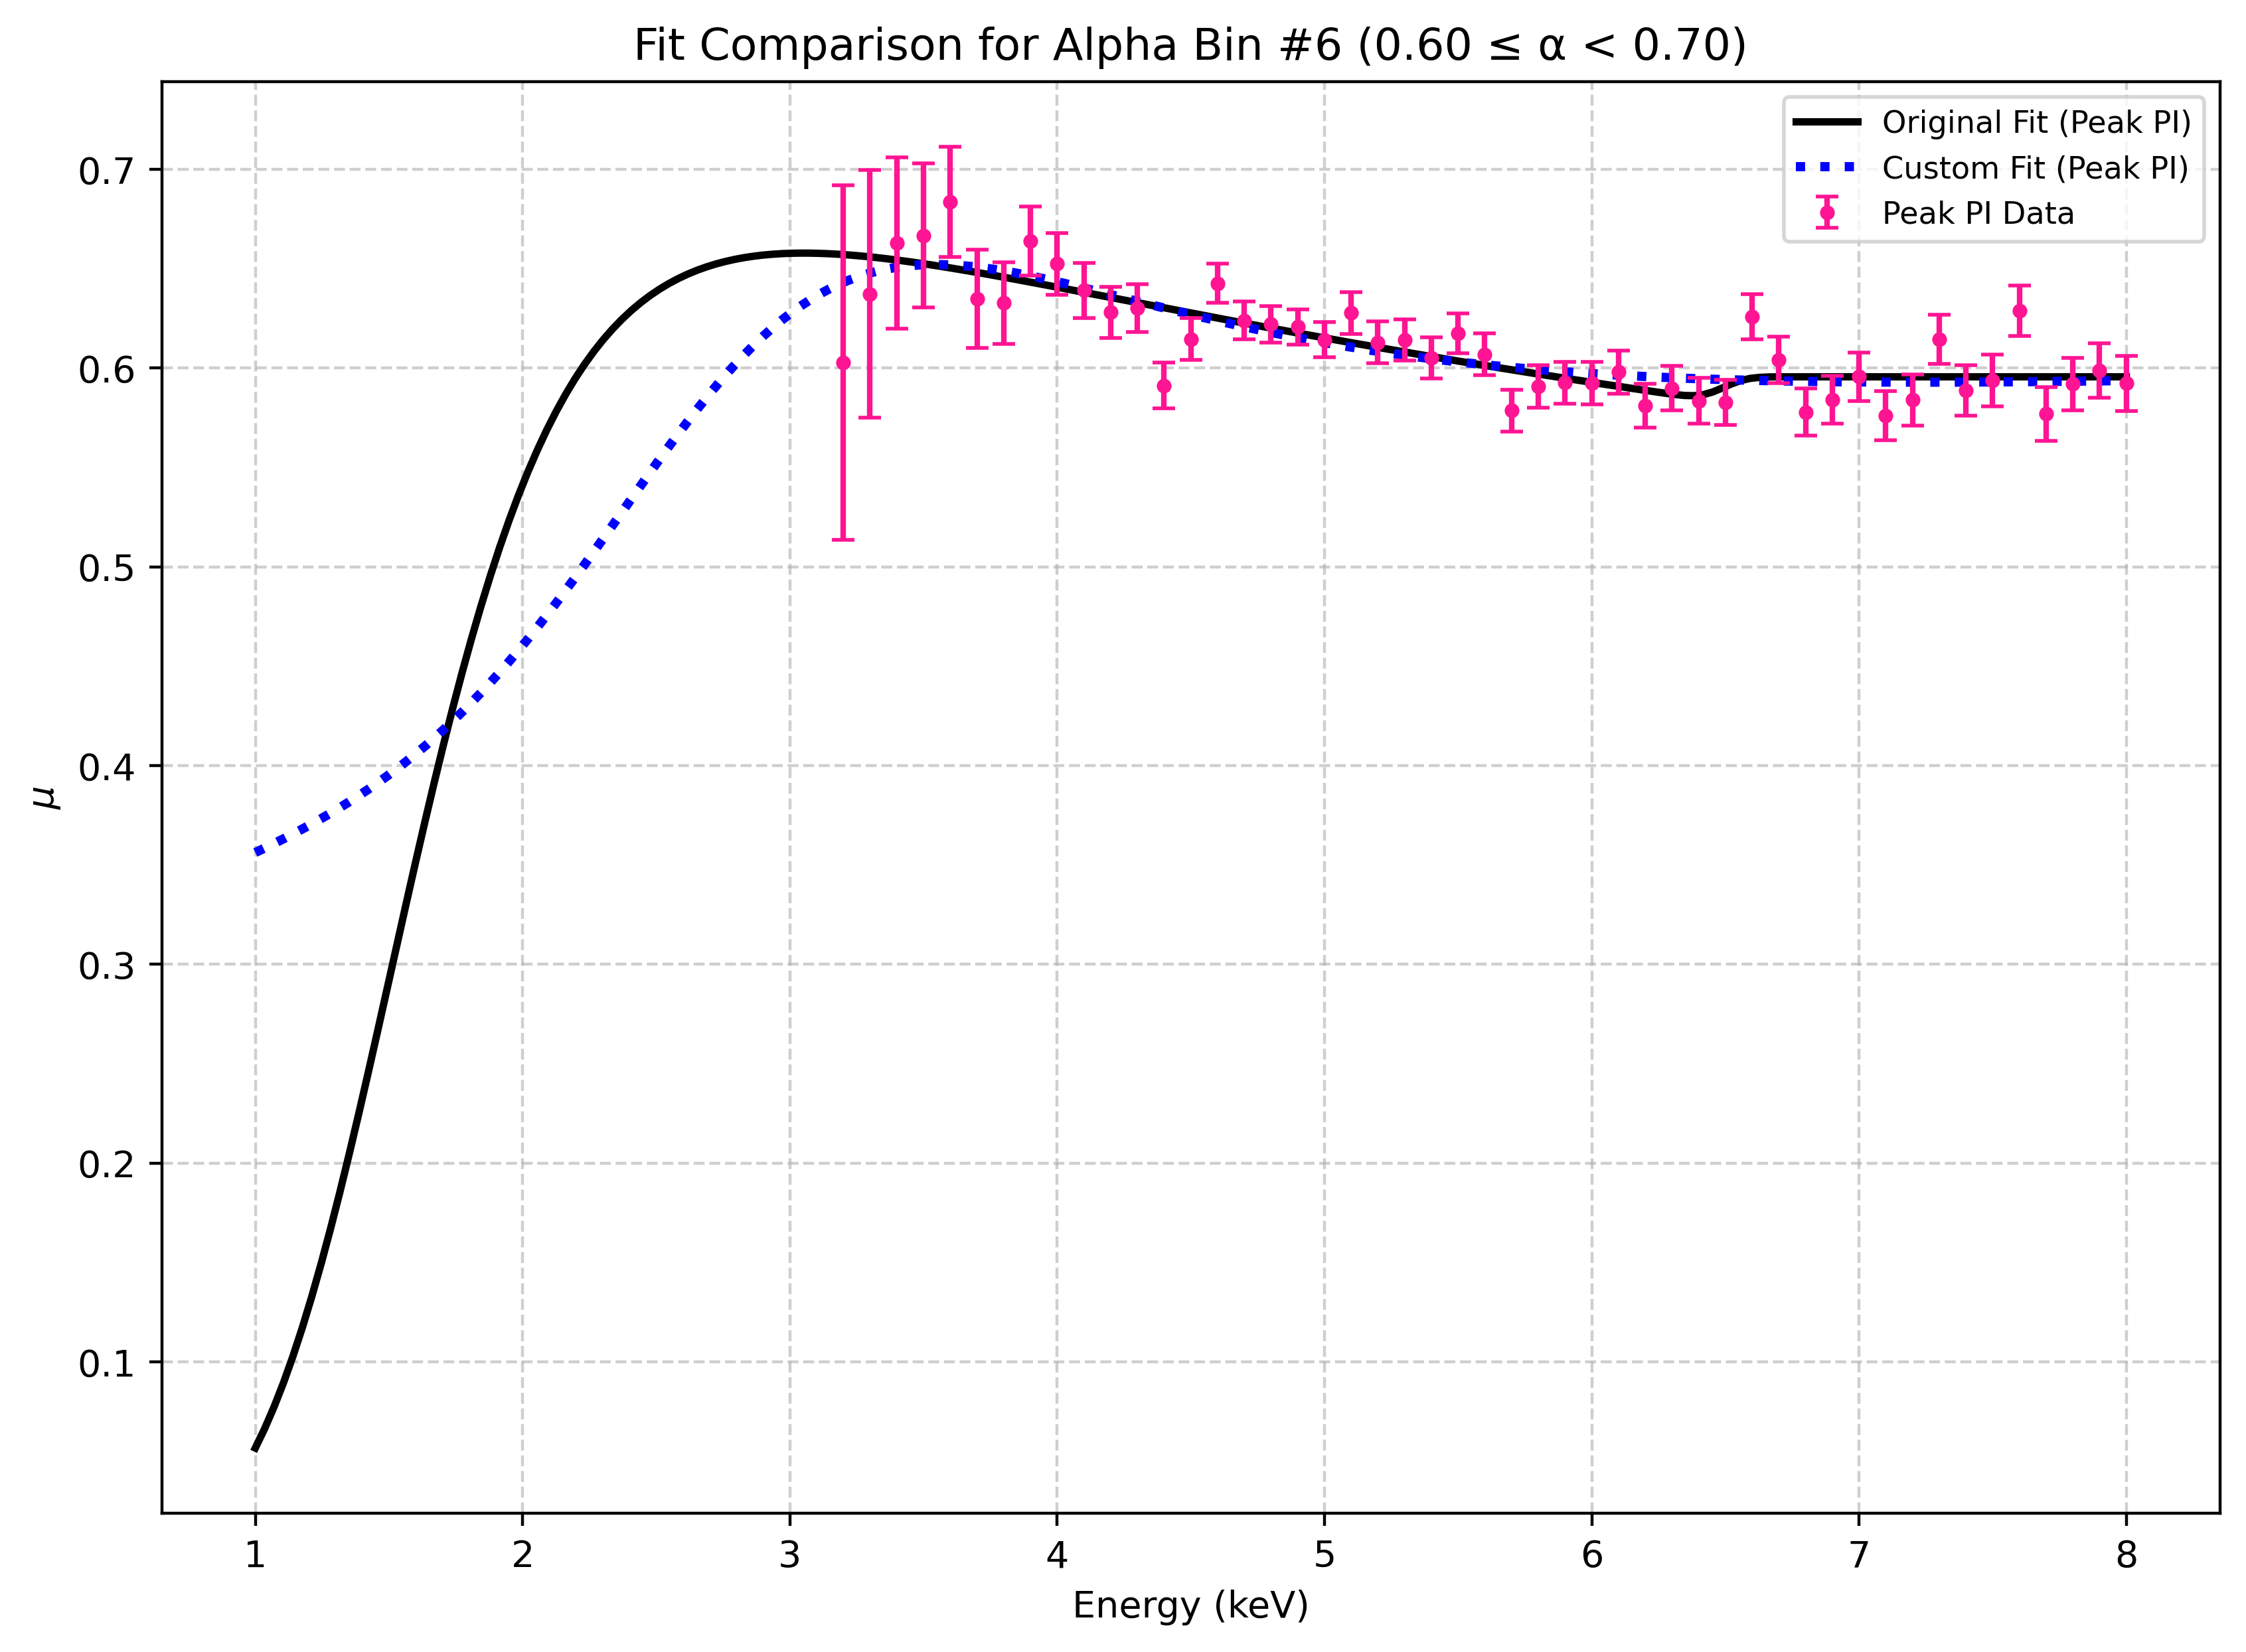

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf

# Ensure the main processing cell (Cell 7) has been run first, so these variables exist:
# all_energies_for_du, all_peak_results_for_du, all_low_results_for_du

# =================================================================================
# --- 1. CONFIGURATION: CHOOSE ALPHA BIN ---
# =================================================================================
# Enter the index of the alpha bin you want to analyze (e.g., 0-9).
alpha_bin_index = 6

# =================================================================================
# --- 2. CUSTOM FIT CONDITIONS ---
# Define your experimental conditions for the blue-colored fit.
# =================================================================================
# Parameters: [A_peak, E_break, alpha1, alpha2, C_tail, E_trans, W_trans]
# Indices:    [   0  ,    1   ,    2  ,    3  ,    4   ,     5   ,     6   ]

# --- For Peak PI Data ---
p0_peak_custom = [1.4, 3, 6, -2.0, 0.113, 6.0, 8]
bounds_peak_custom = ([0, 1.5, 5, -np.inf, 0, 0, 0.1], 
                      [2, 6, np.inf, 0, 1, np.inf, np.inf])
# List of parameter indices to FREEZE at their p0 value (e.g., [1, 2] freezes E_break and alpha1)
params_to_freeze_peak = [0,1]


# --- For Low PI Data ---
p0_low_custom = [0.5, 4.0, 3.0, -2.0, 0.1, 7.0, 2.0]
bounds_low_custom = ([0, 1.0, 0, -np.inf, 0, 4, 0.1],
                     [1, 8, 5, 0, 1, 12, 5.0])
# List of parameter indices to FREEZE at their p0 value
params_to_freeze_low = [] # Empty list means all parameters are free to vary


# =================================================================================


# --- Data Preparation ---
valid_indices = [
    i for i, (p, l, e) in enumerate(zip(all_peak_results_for_du, all_low_results_for_du, all_energies_for_du))
    if p is not None and l is not None and np.isfinite(e)
]
energies = np.array([all_energies_for_du[i] for i in valid_indices])
peak_results = [all_peak_results_for_du[i] for i in valid_indices]
low_results  = [all_low_results_for_du[i] for i in valid_indices]

# --- Extract Data for the Chosen Alpha Bin ---
alpha_bin_centers = peak_results[0]["alpha_bins"]
d_alpha = 1.0 / len(alpha_bin_centers)
alpha_center = alpha_bin_centers[alpha_bin_index]
alpha_low, alpha_high = alpha_center - d_alpha/2.0, alpha_center + d_alpha/2.0
print(f"--- Fitting Alpha Bin #{alpha_bin_index} ({alpha_low:.2f} <= alpha < {alpha_high:.2f}) ---")

mu_peak_slice = np.array([res['mu_bins'][alpha_bin_index] for res in peak_results])
mu_err_peak_slice = np.array([res['mu_bins_err'][alpha_bin_index] for res in peak_results])
mu_low_slice = np.array([res['mu_bins'][alpha_bin_index] for res in low_results])
mu_err_low_slice = np.array([res['mu_bins_err'][alpha_bin_index] for res in low_results])

# --- Perform and Plot Fits ---
fig, ax = plt.subplots(figsize=(10, 7))
e_fit_plot = np.linspace(energies.min(), energies.max(), 200)
param_names = ['A_peak', 'E_break', 'alpha1', 'alpha2', 'C_tail', 'E_trans', 'W_trans']

def calculate_and_print_results(title, y_data, x_data, err_data, popt, frozen_indices=[]):
    residuals = y_data - peak_with_erf_tail(x_data, *popt)
    chi2 = np.sum((residuals / err_data)**2)
    dof = len(x_data) - (len(popt) - len(frozen_indices)) # DoF depends on free parameters
    reduced_chi2 = chi2 / dof if dof > 0 else np.inf
    print(f"\n--- {title} ---")
    print(f"   - Reduced Chi-Squared: {reduced_chi2:.3f} (Chi^2: {chi2:.2f}, DoF: {dof})")
    for i, (name, val) in enumerate(zip(param_names, popt)):
        status = "(frozen)" if i in frozen_indices else ""
        print(f"   - {name:<10}: {val:.3f} {status}")

# --- Peak PI Fits ---
mask_peak = np.isfinite(mu_peak_slice) & (mu_err_peak_slice > 0)
if np.sum(mask_peak) > 6:
    x_peak, y_peak, yerr_peak = energies[mask_peak], mu_peak_slice[mask_peak], mu_err_peak_slice[mask_peak]
    
    # 1. Original Fit (all parameters free)
    try:
        p0_peak_orig = [1, 2, 6, -2.0, 0.1, 6.0, 2.0]
        bounds_peak_orig = ([0, 1.5, 5, -np.inf, 0, 4, 0.1], [2, 6, np.inf, 0, 1, 12, np.inf])
        popt_peak_orig, _ = curve_fit(peak_with_erf_tail, x_peak, y_peak, p0=p0_peak_orig, sigma=yerr_peak, maxfev=10000, bounds=bounds_peak_orig)
        ax.plot(e_fit_plot, peak_with_erf_tail(e_fit_plot, *popt_peak_orig), color='k', ls='-', lw=2, label='Original Fit (Peak PI)')
        calculate_and_print_results("Original Peak PI Fit Results", y_peak, x_peak, yerr_peak, popt_peak_orig)
    except (RuntimeError, ValueError) as e:
        print(f"\n--- Original Peak PI Fit FAILED: {e} ---")

    # 2. Custom Fit (with frozen parameters)
    try:
        # Identify which parameters are free to vary
        free_indices = [i for i in range(len(p0_peak_custom)) if i not in params_to_freeze_peak]
        
        # p0 and bounds only for the free parameters
        p0_free = [p0_peak_custom[i] for i in free_indices]
        bounds_free = ([bounds_peak_custom[0][i] for i in free_indices], 
                       [bounds_peak_custom[1][i] for i in free_indices])
        
        # Wrapper function that fixes the frozen parameters to their p0 values
        def wrapped_model(x, *p_free):
            p_full = list(p0_peak_custom)
            for i, idx in enumerate(free_indices):
                p_full[idx] = p_free[i]
            return peak_with_erf_tail(x, *p_full)
        
        popt_free, _ = curve_fit(wrapped_model, x_peak, y_peak, p0=p0_free, sigma=yerr_peak, maxfev=10000, bounds=bounds_free)
        
        # Reconstruct the full parameter list for plotting and printing
        popt_peak_custom = list(p0_peak_custom)
        for i, idx in enumerate(free_indices):
            popt_peak_custom[idx] = popt_free[i]
            
        ax.plot(e_fit_plot, peak_with_erf_tail(e_fit_plot, *popt_peak_custom), color='blue', ls=':', lw=2.5, label='Custom Fit (Peak PI)')
        calculate_and_print_results("Custom Peak PI Fit Results", y_peak, x_peak, yerr_peak, popt_peak_custom, frozen_indices=params_to_freeze_peak)
    except (RuntimeError, ValueError) as e:
        print(f"\n--- Custom Peak PI Fit FAILED: {e} ---")

# (The Low PI fits section would be updated with the same logic)
# --- Low PI Fits ---
# (Code for Low PI fits would go here, following the same pattern as the Peak PI fits above)

# --- Plot the Data and Finalize ---
ax.errorbar(energies, mu_peak_slice, yerr=mu_err_peak_slice, c='deeppink', fmt='.', capsize=3, label="Peak PI Data")
#ax.errorbar(energies, mu_low_slice, yerr=mu_err_low_slice, c='cornflowerblue', fmt='s', markersize=4, capsize=3, label="Low PI Data")

ax.set(
    title=f"Fit Comparison for Alpha Bin #{alpha_bin_index} ({alpha_low:.2f} ≤ α < {alpha_high:.2f})",
    xlabel="Energy (keV)",
    ylabel=r"$\mu$"
)
ax.legend(fontsize='small')
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()